In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import GPy
from getdist import plots, MCSamples

from gpr4im import fg_tools as fg
from gpr4im import pk_tools as pk

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

# Running GPR analysis on our no polarisation data

Loading data and `pymultinest` nested sampling results for the model:

`RBF (smooth foregrounds) + Exponential (21cm) + zero noise`

In [3]:
data = pd.read_pickle('../../Data/data.pkl')
FGnopol_HI_noise_data = data.beam.FGnopol_HI_noise
HI_noise_data = data.beam.HI_noise
freqs = data.freqs
# multinest results:
multinest_results = pd.read_pickle('../../Data/multinest_results.pkl')
multinest = multinest_results.nopol

Perform PCA removal, to compare with GPR:

In [5]:
pca_res_3 = fg.PCAclean(FGnopol_HI_noise_data, N_FG=3)[0]
pca_res_2 = fg.PCAclean(FGnopol_HI_noise_data, N_FG=2)[0]

We plot below the posterior distribution of our kernel hyperparameters.

In [6]:
samples = multinest.samples
samples[:,0] = samples[:,0]/1e4
samples[:,2] = samples[:,2]/1e-3
weights = multinest.weights

mask = weights > 1e-4

names = ['fgvar', 'fglen', 'expvar', 'explen']
labels =  ['$\sigma^2_\mathrm{smooth}[\mathrm{mK}^2] / 10^4$', '$\ell_\mathrm{smooth}[\mathrm{MHz}]$', 
           '$\sigma^2_{21}[\mathrm{mK}^2] / 10^{-3}$', '$\ell_{21}[\mathrm{MHz}]$']
samples_plot = MCSamples(samples=samples[mask,:], weights=weights[mask], names = names, labels = labels)

Removed no burn in


Optimise kernel model with gradient descent, for comparison with nested sampling:

In [7]:
kern_fg = GPy.kern.RBF(1)
kern_fg.variance.constrain_bounded(1000,100000000)
kern_fg.lengthscale.constrain_bounded(200,10000)
kern_21 = GPy.kern.Exponential(1)
kern_21.variance.constrain_bounded(0.000001,0.5)
kern_21.lengthscale.constrain_bounded(0.01,15)

Input = FGnopol_HI_noise_data

gpr_result_gd = fg.GPRclean(Input, freqs, kern_fg, kern_21, num_restarts=20, NprePCA=0, 
                                        noise_data=None, heteroscedastic=False, zero_noise=True, invert=False)

reconstraining parameters rbf.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters Exponential.variance
reconstraining parameters Exponential.lengthscale
 /opt/anaconda3/envs/testgpr2/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/20, f = -46712129.59083094
Optimization restart 2/20, f = -46243882.70479447
Optimization restart 3/20, f = -46712130.23751642
Optimization restart 4/20, f = -46712130.09670795
Optimization restart 5/20, f = -46712130.70223084
Optimization restart 6/20, f = -46577126.977210134
Optimization restart 7/20, f = -46712130.451451
Optimization restart 8/20, f = -46577170.4399651
Optimization restart 9/20, f = -46712129.9359422
Optimization restart 10/20, f = -46712129.977514625
Optimization restart 11/20, f = -46712130.27583141
Optimization restart 12/20, f = -46712130.35141708
Optimization restart 13/20, f = -46577229.51256907
Optimization restart 14/20, f = -46712130.47695934
Optimization restart 15/20, f = -46577126.58530676
Optimization restart 16/20, f = -46242062.12955919
Optimization restart 17/20, f = -46712129.66465103
Optimization restart 18/20, f = -46230620.18288173
Optimization restart 19/20, f = -46712130.14208546
Optimization restart 20/20, f = -46577110.

In [16]:
gd_results = gpr_result_gd.model.param_array

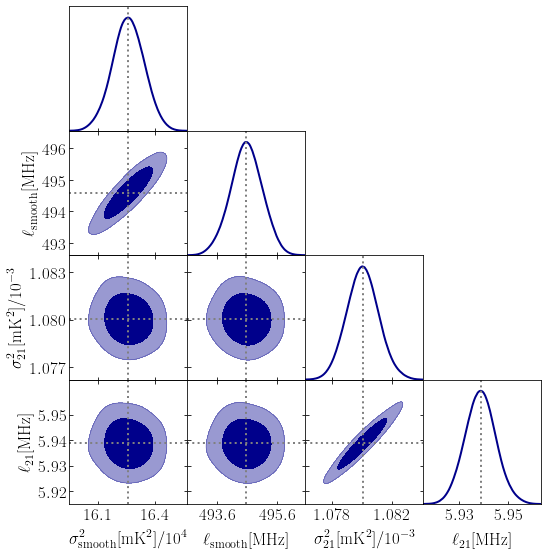

In [22]:
# Triangle plot
g = plots.get_subplot_plotter()
samples_plot.updateSettings({'contours': [0.68, 0.95]})
g.settings.axes_labelsize=20
g.settings.axes_fontsize=20
g.settings.legend_fontsize=22
g.settings.axis_marker_lw=2
g.settings.axis_marker_ls='dotted'
g.triangle_plot([samples_plot], filled=True,
                legend_loc='upper right',
                line_args=[{'lw':2, 'color':'darkblue'}],
                contour_colors=['darkblue'],fontsize=22,
                markers=[gd_results[0]/1e4, gd_results[1], gd_results[2]/1e-3, gd_results[3]])

#g.export('figs/posterior_nopol.pdf')

Perform GPR removal using the kernel model optimised with nested sampling:

In [23]:
kern_fg = GPy.kern.RBF(1, variance = multinest.rbf_var, lengthscale = multinest.rbf_len)
kern_21 = GPy.kern.Exponential(1, variance = multinest.exp_var, lengthscale = multinest.exp_len)

Input = FGnopol_HI_noise_data

gpr_result = fg.GPRclean(Input, freqs, kern_fg, kern_21, num_restarts=0, NprePCA=0, 
                                        noise_data=None, heteroscedastic=False, zero_noise=True, invert=False)

 /opt/anaconda3/envs/testgpr2/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /opt/anaconda3/envs/testgpr2/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Plotting power spectra

In [24]:
# Dimension of data cube:
lx, ly, lz = 1000,1000, 924.78 #Mpc/h
nx, ny, nz = 256, 256, 285
# weighting and window function:
w = W = np.ones((nx,ny,nz))

# minimum and maximum k in each direction:
kmin, kmin_perp, kmin_par = 2*np.pi/pow(lx*ly*lz, 1/3), 2*np.pi/np.sqrt(lx**2 + ly**2), 2*np.pi/lz
kmax, kmax_par, kmax_perp = 0.4, 0.4, 0.4

# set width of k bins to be 2*kmin
dk, dk_perp, dk_par = 2*kmin, 2*kmin_perp, 2*kmin_par

# number of k bins:
nkbin = int((kmax-kmin)/dk)
nkbin_perp = int((kmax_perp-kmin_perp)/dk_perp)
nkbin_par = int((kmax_par-kmin_par)/dk_par)

# setting array of k bin edges:
kbins = np.arange(kmin,kmax,dk)
kbins_perp = np.arange(kmin_perp,kmax_perp,dk_perp)
kbins_par = np.arange(kmin_par,kmax_par,dk_par)

# array of kbin centers:
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)
kperp = np.linspace(kmin_perp+0.5*dk_perp,kmax_perp-0.5*dk_perp,nkbin_perp)
kpar = np.linspace(kmin_par+0.5*dk_par,kmax_par-0.5*dk_par,nkbin_par)

Calculate bias correction:

In [25]:
n_samples = 10
pk3d_corr, pk1d_corr, samples = pk.get_biascorr(gpr_result.fgcov, Input, n_samples, lx, ly, lz, 
                                                kbins_par, kbins, w, W)

Calculate 3D Pk:

In [26]:
# true HI power spectrum:
HI_pk = pk.getpk(HI_noise_data,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

# residual power spectrum from GPR:
GPR_pk = pk.getpk(gpr_result.res,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

# residual power spectrum from GPR, with bias correction:
GPR_pk_bias = GPR_pk + pk3d_corr

# residual power spectrum from PCA:
PCA3_pk = pk.getpk(pca_res_3,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]
PCA2_pk = pk.getpk(pca_res_2,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

Calculate 1D P($k_\parallel$)

In [27]:
# true HI power spectrum:
HI_pk_para = pk.ParaPk(HI_noise_data, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]

# residual power spectrum from GPR:
GPR_pk_para = pk.ParaPk(gpr_result.res, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]

# residual power spectrum from GPR, with bias correction:
GPR_pk_para_bias = GPR_pk_para + pk1d_corr

# residual power spectrum from PCA:
PCA3_pk_para = pk.ParaPk(pca_res_3, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]
PCA2_pk_para = pk.ParaPk(pca_res_2, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]

Calculate 1D P($k_\perp$)

In [28]:
# true HI power spectrum:
HI_pk_perp = pk.PerpPk(HI_noise_data, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]

# residual power spectrum from GPR, with bias correction:
GPR_pk_perp = pk.PerpPk(gpr_result.res, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]

# residual power spectrum from PCA:
PCA3_pk_perp = pk.PerpPk(pca_res_3, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]
PCA2_pk_perp = pk.PerpPk(pca_res_2, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]

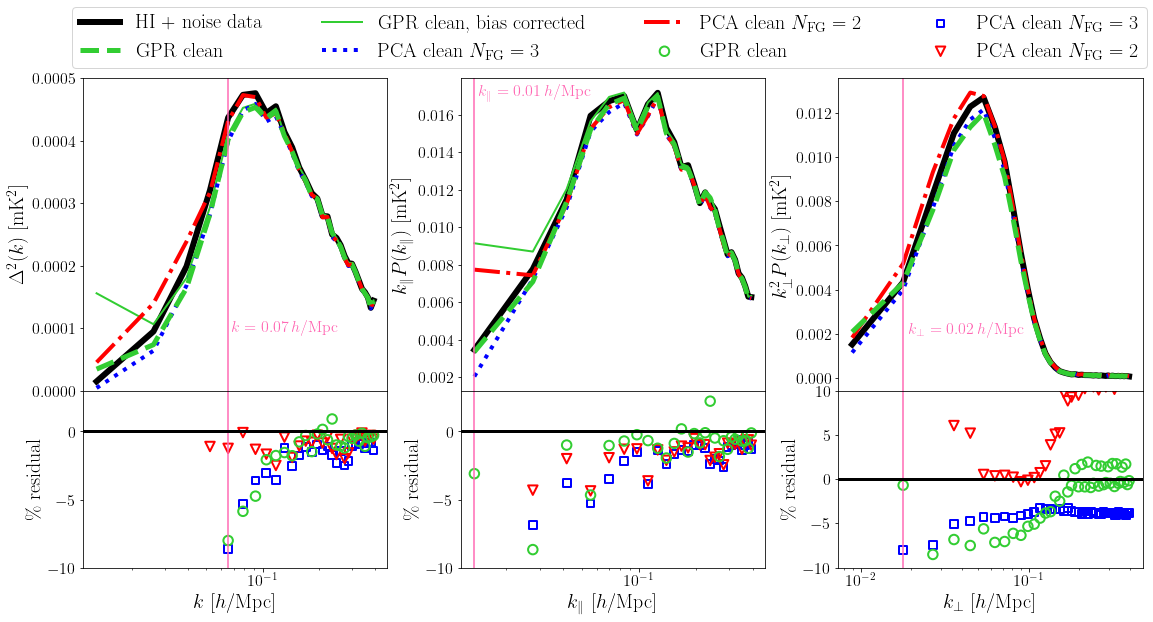

In [26]:
fig, ((ax1, ax3, ax5), (ax2, ax4, ax6)) = plt.subplots(nrows=2, ncols=3, sharex='col', figsize=(19,9), gridspec_kw={'height_ratios': [3, 1.7]})
fig.subplots_adjust(hspace=0, wspace=0.24)

ax1.plot(k, (k*k*k*HI_pk)/(2*np.pi*np.pi), ls='solid', c='k', lw=6, label = r'HI + noise data')
ax1.plot(k, (k*k*k*GPR_pk_bias)/(2*np.pi*np.pi), ls='solid', c='limegreen', lw=2)
ax1.plot(k, (k*k*k*PCA3_pk)/(2*np.pi*np.pi), ls='dotted',c='b', lw=4)
ax1.plot(k, (k*k*k*PCA2_pk)/(2*np.pi*np.pi), ls='dashdot',c='r', lw=4)
ax1.plot(k, (k*k*k*GPR_pk)/(2*np.pi*np.pi), ls='dashed', c='limegreen', lw=5, label = r'GPR clean')
ax1.text(k[0]*5.25, 0.000095, r'$k = 0.07 \, h$/Mpc', c='hotpink')
ax1.axvline(k[4], c='hotpink')
ax1.set_xscale('log')
ax1.set_ylim(0,0.0005)
ax1.set_ylabel('$\Delta^2 (k)$ [mK$^2$]', fontsize=20)

ax2.scatter(k, 100*(PCA3_pk - HI_pk)/HI_pk, marker='s', s=60, edgecolor='b', facecolor='none', lw=2)
ax2.scatter(k, 100*(PCA2_pk - HI_pk)/HI_pk, marker='v', s=90, edgecolor='r', facecolor='none', lw=2)
ax2.scatter(k, 100*(GPR_pk - HI_pk)/HI_pk, s=90, marker='o', edgecolor='limegreen', facecolor='none', lw=2, label = r'GPR clean')
ax2.set_ylim(-10,3)
ax2.axvline(k[4], c='hotpink')
ax2.set_xscale('log')
ax2.set_xlabel('$k$ [$h$/Mpc]', fontsize=20)
ax2.set_ylabel('\% residual', fontsize=20)
ax2.axhline(0, c='k', lw=3)

ax3.plot(kpar, kpar*HI_pk_para, ls='solid', c='k', lw=6)
ax3.plot(kpar, kpar*GPR_pk_para_bias, ls='solid', c='limegreen', lw=2, label=r'GPR clean, bias corrected')
ax3.plot(kpar, kpar*PCA3_pk_para, ls='dotted',c='b', lw=4)
ax3.plot(kpar, kpar*PCA2_pk_para, ls='dashdot',c='r', lw=4)
ax3.plot(kpar, kpar*GPR_pk_para, ls='dashed', c='limegreen', lw=5)
ax3.text(k[0]*1.1, 0.017, r'$k_\parallel = 0.01 \, h$/Mpc', c='hotpink')
ax3.axvline(kpar[0], c='hotpink')
ax3.set_xscale('log')
ax3.set_ylabel('$k_\parallel P(k_\parallel)$ [mK$^2$]', fontsize=20)

ax4.scatter(kpar, 100*(PCA3_pk_para - HI_pk_para)/HI_pk_para, marker='s', s=60, edgecolor='b', facecolor='none', lw=2)
ax4.scatter(kpar, 100*(PCA2_pk_para - HI_pk_para)/HI_pk_para, marker='v', s=90, edgecolor='r', facecolor='none', lw=2)
ax4.scatter(kpar, 100*(GPR_pk_para - HI_pk_para)/HI_pk_para, s=90, marker='o', edgecolor='limegreen', facecolor='none', lw=2)
ax4.axvline(kpar[0], c='hotpink')
ax4.set_ylim(-10,3)
ax4.set_xscale('log')
ax4.set_xlabel('$k_\parallel$ [$h$/Mpc]', fontsize=20)
ax4.set_ylabel('\% residual', fontsize=20)
ax4.axhline(0, c='k', lw=3)

ax5.plot(kperp, kperp*kperp*HI_pk_perp, ls='solid', c='k', lw=6)
ax5.plot(kperp, kperp*kperp*PCA3_pk_perp, ls='dotted',c='b', lw=4, label = r'PCA clean $N_{\rm FG} = 3$')
ax5.plot(kperp, kperp*kperp*PCA2_pk_perp, ls='dashdot',c='r', lw=4, label = r'PCA clean $N_{\rm FG} = 2$')
ax5.plot(kperp, kperp*kperp*GPR_pk_perp, ls='dashed', c='limegreen', lw=5)
ax5.axvline(kperp[1], c='hotpink')
ax5.text(kperp[0]*2.15, 0.002, r'$k_\perp = 0.02 \, h$/Mpc', c='hotpink')
ax5.set_xscale('log')
ax5.set_ylabel('$k_\perp^2 P(k_\perp)$ [mK$^2$]', fontsize=20)

ax6.scatter(kperp, 100*(PCA3_pk_perp - HI_pk_perp)/HI_pk_perp, marker='s', s=60, edgecolor='b', facecolor='none', lw=2, label = r'PCA clean $N_{\rm FG} = 3$')
ax6.scatter(kperp, 100*(PCA2_pk_perp - HI_pk_perp)/HI_pk_perp, marker='v', s=90, edgecolor='r', facecolor='none', lw=2, label = r'PCA clean $N_{\rm FG} = 2$')
ax6.scatter(kperp, 100*(GPR_pk_perp - HI_pk_perp)/HI_pk_perp, s=90, marker='o', edgecolor='limegreen', facecolor='none', lw=2)
ax6.axvline(kperp[1], c='hotpink')
ax6.set_ylim(-10,10)
ax6.set_xlabel('$k_\perp$ [$h$/Mpc]', fontsize=20)
ax6.set_ylabel('\% residual', fontsize=20)
ax6.axhline(0, c='k', lw=3)

fig.legend(bbox_to_anchor=(0.11, 0.88, 0.8, 0), loc="lower left", mode="expand", ncol=4, fontsize=20)

#plt.savefig('figs/pk_all_nopol', dpi=300, bbox_inches="tight")